# DEMO: Exploratory Data Analysis (EDA) module functionalities

This notebook provides a demo of how to utilise the EDA module.
Things to present:
- categorical data
- [ ] countplot
    - [x] count user barplot
    - [x] count group boxplot
    - [x] value group boxplot
- [ ] lineplot
- [ ] missingness
- [ ] punchcard

In [1]:
import os
import sys
sys.path.append('../')


import numpy as np
import pandas as pd
import niimpy

from niimpy.preprocessing.survey import *
from niimpy.exploration import EDA_categorical, EDA_countplot, EDA_lineplot, EDA_missingness, EDA_punchcard


## 1) Categorical plot

## Load data
We will load a mock survey data file.

In [2]:
# go to paretn directory
os.chdir('..')
# Get the current working directory
cwd = os.getcwd()

# Print the current working directory
print("Current working directory: {0}".format(cwd))

data_folder = os.path.join(cwd,"niimpy","sampledata","mock-survey.csv")
print(data_folder)

from pathlib import Path

data_folder = Path(data_folder)
print(data_folder)



Current working directory: D:\niimpy
D:\niimpy\niimpy\sampledata\mock-survey.csv
D:\niimpy\niimpy\sampledata\mock-survey.csv


In [3]:
# Load a mock dataframe
df = niimpy.read_csv(data_folder,tz='Europe/Helsinki')
df.head()

user  age  gender Little interest or pleasure in doing things.  \
0     1   20    Male                                 several-days   
1     2   32    Male                      more-than-half-the-days   
2     3   15    Male                      more-than-half-the-days   
3     4   35  Female                                   not-at-all   
4     5   23    Male                      more-than-half-the-days   

  Feeling down; depressed or hopeless. Feeling nervous; anxious or on edge.  \
0              more-than-half-the-days                           not-at-all   
1              more-than-half-the-days                           not-at-all   
2                           not-at-all                         several-days   
3                     nearly-every-day                           not-at-all   
4                           not-at-all              more-than-half-the-days   

  Not being able to stop or control worrying.  \
0                            nearly-every-day   
1                                several-days   
2                                  not-at-all   
3                                several-days   
4                                several-days   

  In the last month; how often have you felt that you were unable to control the important things in your life?  \
0                                       almost-never                                                              
1                                              never                                                              
2                                              never                                                              
3                                         very-often                                                              
4                                       almost-never                                                              

  In the last month; how often have you felt confident about your ability to handle your personal problems?  \
0                                          sometimes                                                          
1                                              never                                                          
2                                         very-often                                                          
3                                       fairly-often                                                          
4                                         very-often                                                          

  In the last month; how often have you felt that things were going your way?  \
0                                       fairly-often                            
1                                         very-often                            
2                                         very-often                            
3                                         very-often                            
4                                       almost-never                            

  In the last month; how often have you been able to control irritations in your life?  \
0                                              never                                     
1                                          sometimes                                     
2                                       fairly-often                                     
3                                              never                                     
4                                          sometimes                                     

  In the last month; how often have you felt that you were on top of things?  \
0                                          sometimes                           
1                                              never                           
2                                              never                           
3                                          sometimes                           
4                               

In [4]:
df.describe()

user          age
count  1000.000000  1000.000000
mean    500.500000    26.911000
std     288.819436     4.992595
min       1.000000    12.000000
25%     250.750000    23.000000
50%     500.500000    27.000000
75%     750.250000    30.000000
max    1000.000000    43.000000

## Preprocessing 
The dataframe's columns are raw questions from a survey. Some questions belong to a specific category, so we will annotate them with ids. The id is constructed from a prefix (the questionnaire category: GAD, PHQ, PSQI etc.), followed by the question number (1,2,3). Similarly, we will also the answers to meaningful numerical values.

**Note:** It's important that the dataframe follows the below schema before passing into niimpy.

In [5]:
# Convert column name to id, based on provided mappers from niimpy
col_id = {**PHQ2_MAP, **PSQI_MAP, **PSS10_MAP, **PANAS_MAP, **GAD2_MAP}
selected_cols = [col for col in df.columns if col in col_id.keys()]

# Convert data frame to long format
m_df = pd.melt(df, id_vars=['user', 'age', 'gender'], value_vars=selected_cols, var_name='question', value_name='answer')

# Assign questions to codes 
m_df['id'] = m_df['question'].replace(col_id)
m_df.head()

user  age  gender                                      question  \
0     1   20    Male  Little interest or pleasure in doing things.   
1     2   32    Male  Little interest or pleasure in doing things.   
2     3   15    Male  Little interest or pleasure in doing things.   
3     4   35  Female  Little interest or pleasure in doing things.   
4     5   23    Male  Little interest or pleasure in doing things.   

                    answer      id  
0             several-days  PHQ2_1  
1  more-than-half-the-days  PHQ2_1  
2  more-than-half-the-days  PHQ2_1  
3               not-at-all  PHQ2_1  
4  more-than-half-the-days  PHQ2_1

We can use a helper method to convert the answers into numerical value. The pre-defined mapper inside survey.py would be useful for this step.

In [6]:
# Transform raw answers to numerical values
m_df['answer'] = niimpy.preprocessing.survey.convert_to_numerical_answer(m_df, answer_col = 'answer',
                                question_id = 'id', id_map=ID_MAP_PREFIX, use_prefix=True)
m_df.head()

user  age  gender                                      question answer  \
0     1   20    Male  Little interest or pleasure in doing things.      1   
1     2   32    Male  Little interest or pleasure in doing things.      2   
2     3   15    Male  Little interest or pleasure in doing things.      2   
3     4   35  Female  Little interest or pleasure in doing things.      0   
4     5   23    Male  Little interest or pleasure in doing things.      2   

       id  
0  PHQ2_1  
1  PHQ2_1  
2  PHQ2_1  
3  PHQ2_1  
4  PHQ2_1

We can also produce a summary of the questionaire's score. This function can describe aggregated score over the whole population, or specific subgroups.

In [7]:
d = niimpy.preprocessing.survey.print_statistic(m_df)
pd.DataFrame(d)

PHQ2      PSS10      GAD2
min  0.0000   4.000000  0.000000
max  6.0000  27.000000  6.000000
avg  3.0520  14.006000  3.042000
std  1.5855   3.687759  1.536423

In [8]:
d = niimpy.preprocessing.survey.print_statistic(m_df, group='gender')
pd.DataFrame(d)

PHQ2                PSS10                 GAD2          
       Female      Male     Female       Male    Female      Male
min  0.000000  0.000000   4.000000   4.000000  0.000000  0.000000
max  6.000000  6.000000  27.000000  23.000000  6.000000  6.000000
avg  3.067210  3.037328  14.059063  13.954813  3.087576  2.998035
std  1.605337  1.567567   3.783230   3.596247  1.585157  1.488141

In [9]:
d = niimpy.preprocessing.survey.print_statistic(m_df, group='gender', prefix='PHQ')
pd.DataFrame(d)

## TODO: Add a method to categorize score into levels
## TODO: Extend to demographics info

PHQ          
       Female      Male
min  0.000000  0.000000
max  6.000000  6.000000
avg  3.067210  3.037328
std  1.605337  1.567567

## Visualization

We can now make some plots for the preprocessed data frame. First, we can display the summary for a specific question.

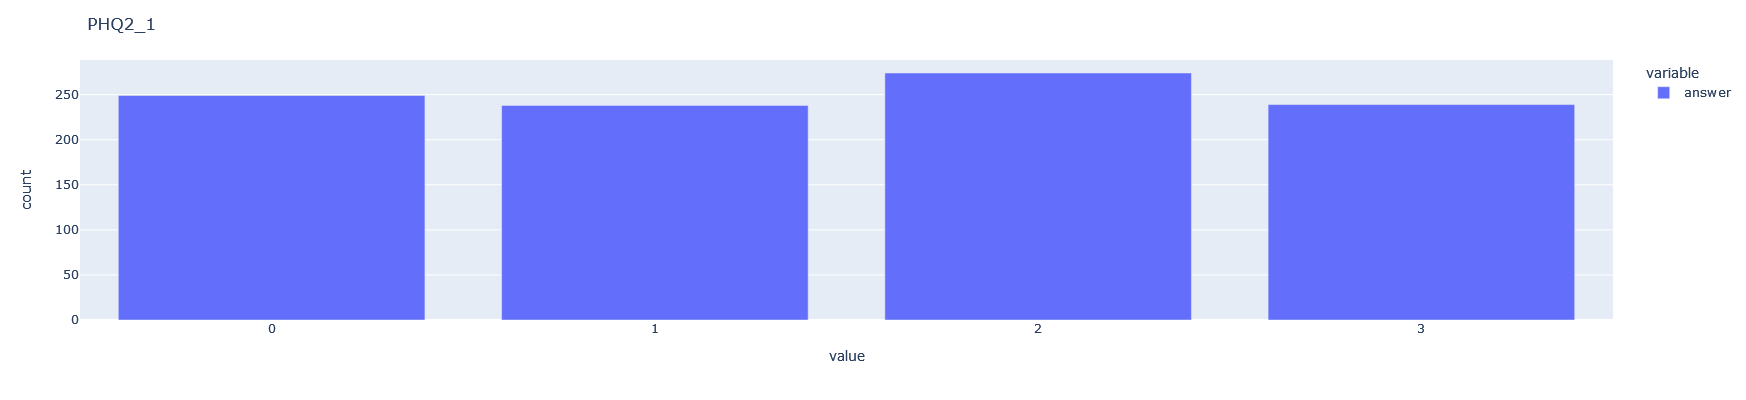

In [10]:
fig = EDA_categorical.questionnaire_summary(m_df, question = 'PHQ2_1', column = 'answer', 
                                                       title='PHQ2_1', xlabel='value', ylabel='count', 
                                                       width=600, height=400)
fig.show()

We can also display the summary for each subgroup.

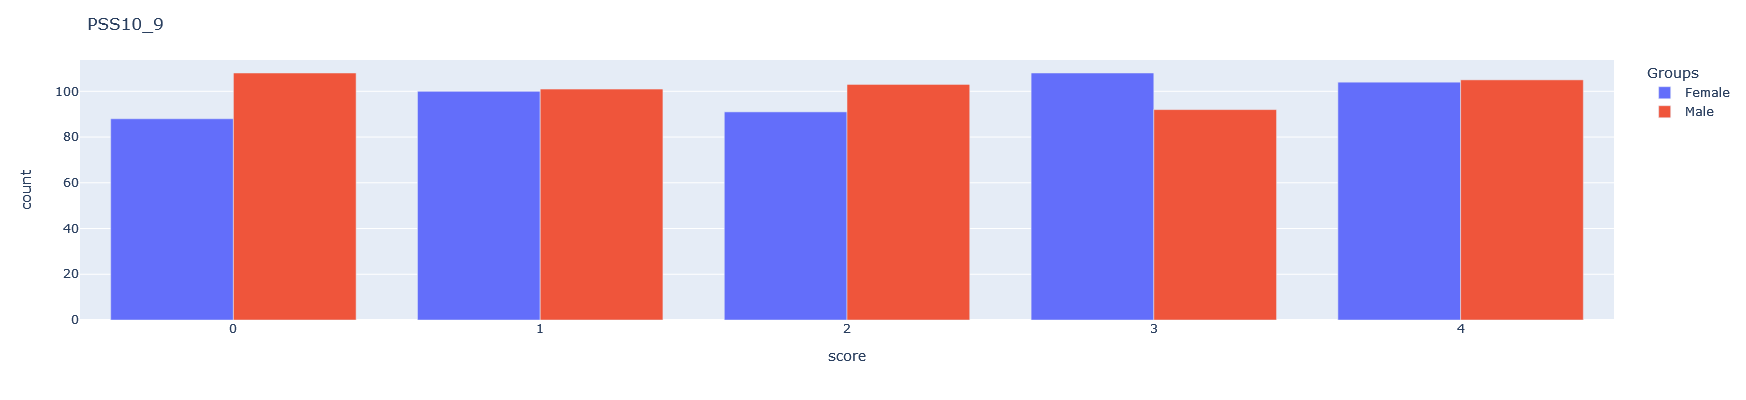

In [11]:
fig = EDA_categorical.questionnaire_grouped_summary(m_df, question='PSS10_9', group='gender', 
                                                               title='PSS10_9',
                                                               xlabel='score', ylabel='count',
                                                               width=800, height=400)
fig.show()

With some quick preprocessing, we can display the score distribution of each questionaire.

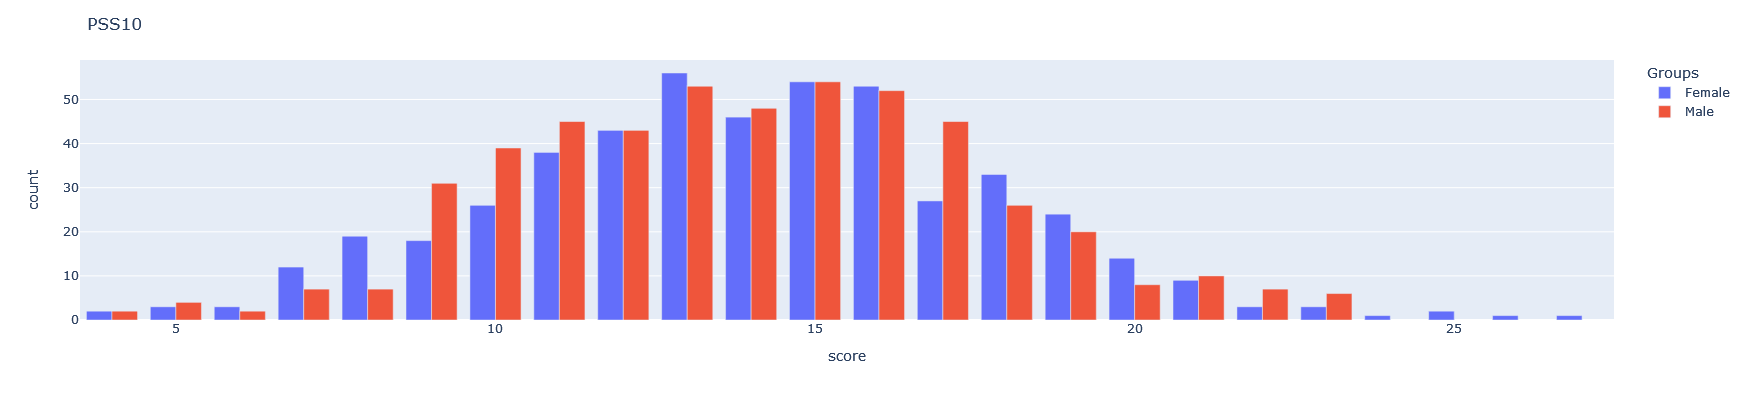

In [12]:
pss_sum_df = m_df[m_df['id'].str.startswith('PSS')] \
                            .groupby(['user', 'gender']) \
                            .agg({'answer':sum}) \
                            .reset_index()
pss_sum_df['id'] = 'PSS'
fig = EDA_categorical.questionnaire_grouped_summary(pss_sum_df, question='PSS', group='gender', 
                                                               title='PSS10',
                                                               xlabel='score', ylabel='count',
                                                               width=800, height=400)
fig.show()

## 2) Countplot

In [13]:
m_df.loc[:10,:]

user  age  gender                                      question answer  \
0      1   20    Male  Little interest or pleasure in doing things.      1   
1      2   32    Male  Little interest or pleasure in doing things.      2   
2      3   15    Male  Little interest or pleasure in doing things.      2   
3      4   35  Female  Little interest or pleasure in doing things.      0   
4      5   23    Male  Little interest or pleasure in doing things.      2   
5      6   31  Female  Little interest or pleasure in doing things.      0   
6      7   30    Male  Little interest or pleasure in doing things.      0   
7      8   23    Male  Little interest or pleasure in doing things.      2   
8      9   32    Male  Little interest or pleasure in doing things.      3   
9     10   30    Male  Little interest or pleasure in doing things.      3   
10    11   24    Male  Little interest or pleasure in doing things.      0   

        id  
0   PHQ2_1  
1   PHQ2_1  
2   PHQ2_1  
3   PHQ2_1  
4   PHQ2_1  
5   PHQ2_1  
6   PHQ2_1  
7   PHQ2_1  
8   PHQ2_1  
9   PHQ2_1  
10  PHQ2_1

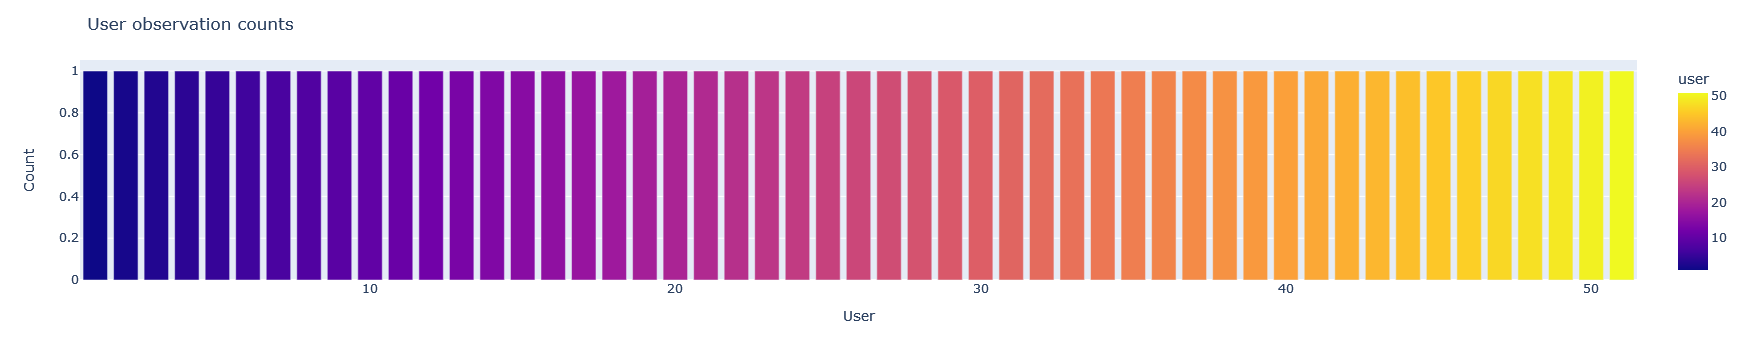

In [14]:
EDA_countplot.EDA_countplot(m_df.loc[:50,:],
              fig_title = 'User observation counts', 
              plot_type = 'count', 
              points = 'all',
              aggregation = 'user', 
              user = None, 
              column='answer')

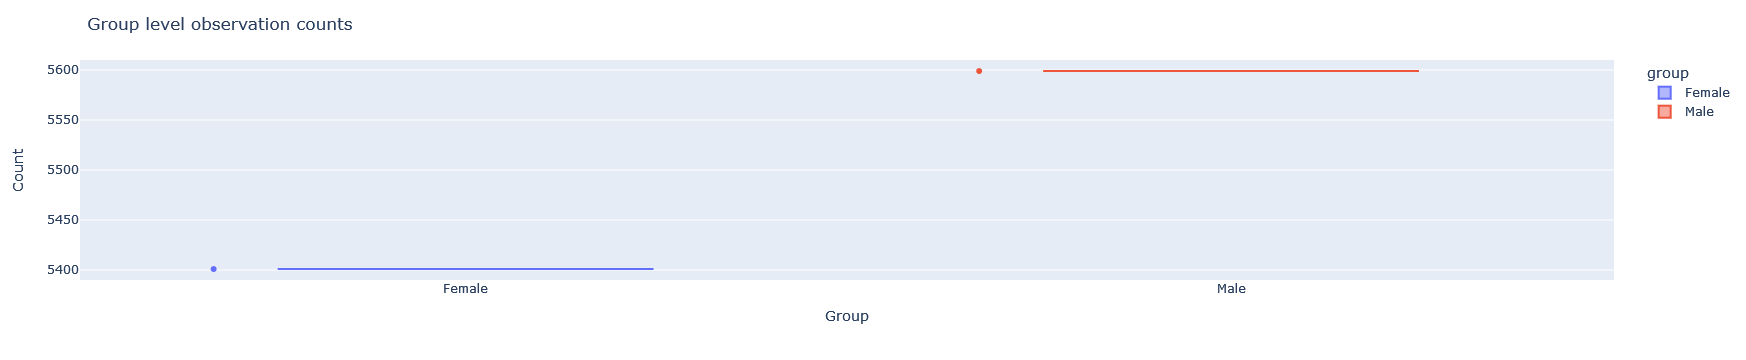

In [15]:
m_df.rename(columns={"gender": "group",},inplace=True)
EDA_countplot.EDA_countplot(m_df,
              fig_title = 'Group level observation counts', 
              plot_type = 'count', 
              points = 'all',
              aggregation = 'group', 
              user = None, 
            )

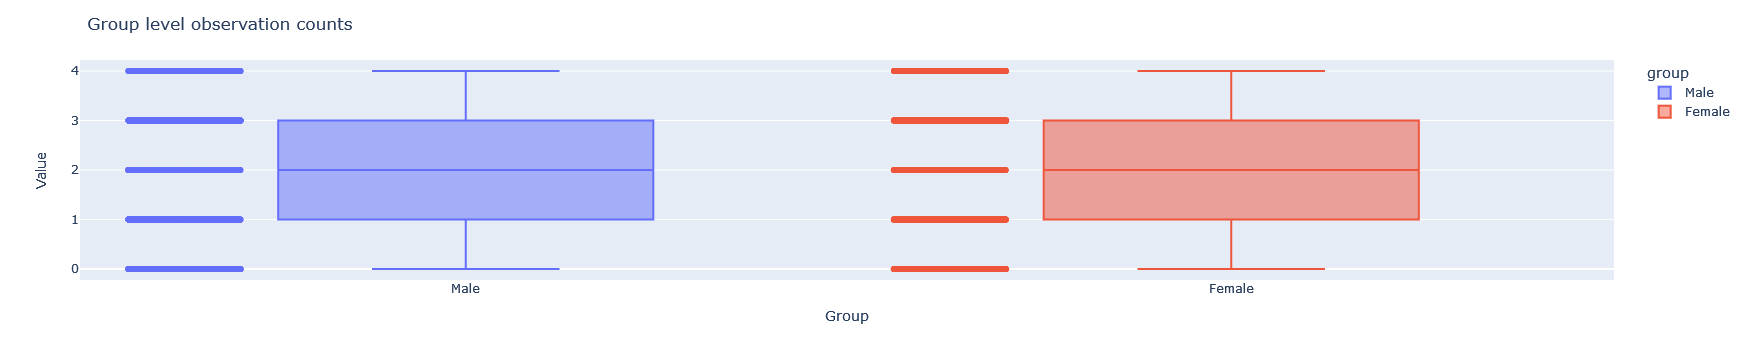

In [16]:
EDA_countplot.EDA_countplot(m_df,
                            fig_title = 'Group level observation counts', 
                            plot_type = 'value', 
                            points = 'all',
                            aggregation = 'group', 
                            user = None,
                            column = 'answer',
                            binning = False
                            )



## 3) Lineplot


## 4) Punchcard

In [105]:
cwd = os.getcwd()

# Print the current working directory
print("Current working directory: {0}".format(cwd))



Current working directory: D:\niimpy


In [168]:
import glob
import pandas as pd

# get data file names
path = r'E:\SpecialAssignment\StudentLife\dataset\sensing\activity'
filenames = glob.glob(path + "\*.csv")

dfs = []
for filename in filenames:
    df = pd.read_csv(filename)
    df['user'] = filename[-7:-4]
    dfs.append(df)
# Concatenate all data into one DataFrame
big_frame = pd.concat(dfs, ignore_index=False)

In [170]:
big_frame['timestamp'] = pd.to_datetime(big_frame['timestamp'],unit='s')

big_frame

timestamp   activity inference user
0       2013-03-27 04:00:01                    0  u00
1       2013-03-27 04:00:04                    0  u00
2       2013-03-27 04:00:07                    0  u00
3       2013-03-27 04:00:09                    0  u00
4       2013-03-27 04:03:12                    0  u00
...                     ...                  ...  ...
1945362 2013-06-01 03:59:51                    0  u59
1945363 2013-06-01 03:59:53                    0  u59
1945364 2013-06-01 03:59:55                    0  u59
1945365 2013-06-01 03:59:57                    0  u59
1945366 2013-06-01 03:59:59                    0  u59

[22842191 rows x 3 columns]

In [171]:
big_frame = big_frame.set_index('timestamp')


In [172]:
#big_frame = big_frame.tz_localize(tz='US/Central')
big_frame = big_frame.tz_localize('UTC').tz_convert('US/Central')

In [173]:
big_frame

activity inference user
timestamp                                          
2013-03-26 23:00:01-05:00                    0  u00
2013-03-26 23:00:04-05:00                    0  u00
2013-03-26 23:00:07-05:00                    0  u00
2013-03-26 23:00:09-05:00                    0  u00
2013-03-26 23:03:12-05:00                    0  u00
...                                        ...  ...
2013-05-31 22:59:51-05:00                    0  u59
2013-05-31 22:59:53-05:00                    0  u59
2013-05-31 22:59:55-05:00                    0  u59
2013-05-31 22:59:57-05:00                    0  u59
2013-05-31 22:59:59-05:00                    0  u59

[22842191 rows x 2 columns]

In [214]:
activity_df = big_frame.loc[big_frame[' activity inference'].isin([1,2])]
activity_df.head()

activity inference user
timestamp                                          
2013-03-27 06:27:29-05:00                    1  u00
2013-03-27 06:27:34-05:00                    1  u00
2013-03-27 06:27:37-05:00                    1  u00
2013-03-27 06:27:39-05:00                    1  u00
2013-03-27 06:27:41-05:00                    1  u00

In [235]:
activity_rs = activity_df.groupby('user').resample('12min').size().reset_index()
activity_rs =  activity_rs.set_index(activity_rs.timestamp)
activity_rs = activity_rs.drop(columns=['timestamp'])
activity_rs[0] = [0 if x == 0 else 1 for x in activity_rs[0].values]
activity_rs

user  0
timestamp                        
2013-03-27 06:24:00-05:00  u00  1
2013-03-27 06:36:00-05:00  u00  0
2013-03-27 06:48:00-05:00  u00  1
2013-03-27 07:00:00-05:00  u00  1
2013-03-27 07:12:00-05:00  u00  0
...                        ... ..
2013-05-31 21:24:00-05:00  u59  1
2013-05-31 21:36:00-05:00  u59  1
2013-05-31 21:48:00-05:00  u59  1
2013-05-31 22:00:00-05:00  u59  0
2013-05-31 22:12:00-05:00  u59  1

[357922 rows x 2 columns]

In [242]:
af = activity_rs.groupby('user').resample('H').sum().reset_index()
af = af.set_index(af.timestamp)
af = af.drop(columns=['timestamp'])
af.rename(columns={'user': 'user', 0: 'activity'}, inplace=True)
af

user  activity
timestamp                               
2013-03-27 06:00:00-05:00  u00         2
2013-03-27 07:00:00-05:00  u00         1
2013-03-27 08:00:00-05:00  u00         2
2013-03-27 09:00:00-05:00  u00         3
2013-03-27 10:00:00-05:00  u00         4
...                        ...       ...
2013-05-31 18:00:00-05:00  u59         5
2013-05-31 19:00:00-05:00  u59         5
2013-05-31 20:00:00-05:00  u59         4
2013-05-31 21:00:00-05:00  u59         5
2013-05-31 22:00:00-05:00  u59         1

[71627 rows x 2 columns]

In [243]:
survey_path = r'E:\SpecialAssignment\StudentLife\dataset\survey\PHQ-9.csv'

phq9 = pd.read_csv(survey_path)
phq9

uid  type Little interest or pleasure in doing things  \
0   u00   pre                                  Not at all   
1   u01   pre                                Several days   
2   u02   pre                     More than half the days   
3   u03   pre                                  Not at all   
4   u04   pre                                Several days   
..  ...   ...                                         ...   
79  u52  post                                Several days   
80  u53  post                                  Not at all   
81  u56  post                                  Not at all   
82  u58  post                                  Not at all   
83  u59  post                                  Not at all   

   Feeling down, depressed, hopeless.  \
0                        Several days   
1                        Several days   
2                        Several days   
3                        Several days   
4                        Several days   
..                                ...   
79                   Nearly every day   
80                       Several days   
81                         Not at all   
82                       Several days   
83                         Not at all   

   Trouble falling or staying asleep, or sleeping too much.  \
0                                          Not at all         
1                                        Several days         
2                             More than half the days         
3                                          Not at all         
4                                          Not at all         
..                                                ...         
79                                   Nearly every day         
80                                   Nearly every day         
81                                         Not at all         
82                                         Not at all         
83                            More than half the days         

   Feeling tired or having little energy Poor appetite or overeating  \
0                           Several days                  Not at all   
1                           Several days                  Not at all   
2                More than half the days     More than half the days   
3                             Not at all                  Not at all   
4                           Several days                Several days   
..                                   ...                         ...   
79               More than half the days            Nearly every day   
80               More than half the days            Nearly every day   
81               More than half the days                  Not at all   
82               More than half the days     More than half the days   
83               More than half the days                Several days   

   Feeling bad about yourself or that you are a failure or have let yourself or your family down  \
0                                          Not at all                                              
1                                        Several days                                              
2                                        Several days                                              
3                                          Not at all                                              
4                                        Several days                                              
..                                                ...                                              
79                                       Several days                                              
80                                         Not at all                                              
81                                         Not at all                                              
82                                       Several days                                              
83                                         Not at all   

In [244]:
PHQ9_ANSWER_MAP = {
    'Not at all': 0,
    'Several days': 1,
    'More than half the days': 2,
    'Nearly every day': 3}





In [245]:
for column in phq9:
    if column not in ['uid','type','Response']:
        phq9[column] = phq9[column].map(PHQ9_ANSWER_MAP)

In [246]:
phq9.dtypes

uid                                                                                                                                                                      object
type                                                                                                                                                                     object
Little interest or pleasure in doing things                                                                                                                               int64
Feeling down, depressed, hopeless.                                                                                                                                        int64
Trouble falling or staying asleep, or sleeping too much.                                                                                                                  int64
Feeling tired or having little energy                                                                                   

In [247]:
phq9['total'] = phq9.iloc[:,2:11].sum(axis=1)

array([[<AxesSubplot:title={'center':'total'}>]], dtype=object)

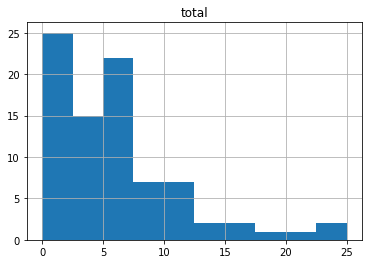

In [248]:
phq9.hist(column = 'total')

In [249]:
def dep(x):
    if 0 <= x <= 4:
        y = 'none'
    elif 5 <= x <= 9:
        y = 'mild'
    elif 10 <= x <= 14:
        y = 'moderate'
    elif 15 <= x <= 19:
        y = 'moderately severe'
    else:
        y = 'severe'
    
    return y
        
phq9['dep'] = [dep(x) for x in phq9['total']]


<AxesSubplot:xlabel='uid'>

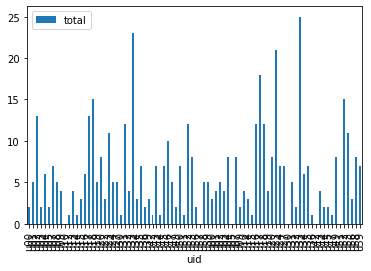

In [250]:
phq9.plot.bar(x='uid',y='total')

In [251]:
pre_val = phq9[phq9['type'] == 'pre'][['uid','total']]
post_val = phq9[phq9['type'] == 'post'][['uid','total']]

In [252]:
vals = pd.merge(pre_val,post_val,on='uid')

In [253]:
vals['mean'] = (vals.total_x + vals.total_y) / 2

In [254]:
vals['dep'] = [dep(x) for x in vals['mean']]

In [255]:
vals

uid  total_x  total_y  mean                dep
0   u00        2        3   2.5               none
1   u01        5        4   4.5             severe
2   u02       13        5   9.0               mild
3   u03        2        4   3.0               none
4   u04        6        8   7.0               mild
5   u05        2        0   1.0               none
6   u07        7        8   7.5               mild
7   u09        4        2   3.0               none
8   u10        0        4   2.0               none
9   u14        1        3   2.0               none
10  u15        3        1   2.0               none
11  u16        6       12   9.0               mild
12  u17       13       18  15.5  moderately severe
13  u18       15       12  13.5           moderate
14  u19        5        4   4.5             severe
15  u20        8        8   8.0               mild
16  u23       11       21  16.0  moderately severe
17  u24        5        7   6.0               mild
18  u27        5        7   6.0               mild
19  u30        1        0   0.5               none
20  u31       12        5   8.5               mild
21  u32        4        2   3.0               none
22  u33       23       25  24.0             severe
23  u34        3        6   4.5             severe
24  u35        7        7   7.0               mild
25  u36        2        1   1.5               none
26  u42        1        0   0.5               none
27  u43        7        4   5.5               mild
28  u44        1        2   1.5               none
29  u45        7        2   4.5             severe
30  u47        5        1   3.0               none
31  u49        2        8   5.0               mild
32  u51        1        0   0.5               none
33  u52       12       15  13.5           moderate
34  u53        8       11   9.5             severe
35  u56        2        3   2.5               none
36  u58        5        8   6.5               mild
37  u59        5        7   6.0               mild

In [256]:
af = af.astype({'user':'str'})

In [257]:
af

user  activity
timestamp                               
2013-03-27 06:00:00-05:00  u00         2
2013-03-27 07:00:00-05:00  u00         1
2013-03-27 08:00:00-05:00  u00         2
2013-03-27 09:00:00-05:00  u00         3
2013-03-27 10:00:00-05:00  u00         4
...                        ...       ...
2013-05-31 18:00:00-05:00  u59         5
2013-05-31 19:00:00-05:00  u59         5
2013-05-31 20:00:00-05:00  u59         4
2013-05-31 21:00:00-05:00  u59         5
2013-05-31 22:00:00-05:00  u59         1

[71627 rows x 2 columns]

In [258]:
sf = af[af['user'] != 'u08']

In [259]:
sf

user  activity
timestamp                               
2013-03-27 06:00:00-05:00  u00         2
2013-03-27 07:00:00-05:00  u00         1
2013-03-27 08:00:00-05:00  u00         2
2013-03-27 09:00:00-05:00  u00         3
2013-03-27 10:00:00-05:00  u00         4
...                        ...       ...
2013-05-31 18:00:00-05:00  u59         5
2013-05-31 19:00:00-05:00  u59         5
2013-05-31 20:00:00-05:00  u59         4
2013-05-31 21:00:00-05:00  u59         5
2013-05-31 22:00:00-05:00  u59         1

[70102 rows x 2 columns]

In [260]:
sf = sf[sf['user'] != 'u12']

In [261]:
sf = sf[sf['user'] != 'u13']

In [262]:
sf = sf[sf['user'] != 'u22']

In [263]:
sf = sf[sf['user'] != 'u25']

In [264]:
sf = sf[sf['user'] != 'u39']

In [265]:
sf = sf[sf['user'] != 'u41']

In [266]:
sf = sf[sf['user'] != 'u46']

In [267]:
sf = sf[sf['user'] != 'u50']

In [268]:
sf = sf[sf['user'] != 'u54']


In [269]:
sf = sf[sf['user'] != 'u57']

In [270]:
sf

user  activity
timestamp                               
2013-03-27 06:00:00-05:00  u00         2
2013-03-27 07:00:00-05:00  u00         1
2013-03-27 08:00:00-05:00  u00         2
2013-03-27 09:00:00-05:00  u00         3
2013-03-27 10:00:00-05:00  u00         4
...                        ...       ...
2013-05-31 18:00:00-05:00  u59         5
2013-05-31 19:00:00-05:00  u59         5
2013-05-31 20:00:00-05:00  u59         4
2013-05-31 21:00:00-05:00  u59         5
2013-05-31 22:00:00-05:00  u59         1

[55907 rows x 2 columns]

In [272]:
user_map = dict(zip(vals.uid,vals.dep))

deps = []

for i in range(0,sf.shape[0]):
    user = sf.iloc[i,0]
    deps.append(user_map[user])
                          

In [274]:
len(deps)

55907

In [56]:
D = np.array(deps)

In [57]:
D= D.reshape(-1,1)

In [58]:
D.shape

(56953, 1)

In [59]:

iso_D = [d[0][0] for d in D]    

In [275]:

sf['depression'] = deps

In [276]:
sf['group'] = deps


In [278]:
sf = sf.drop(columns=['depression'])

<AxesSubplot:>

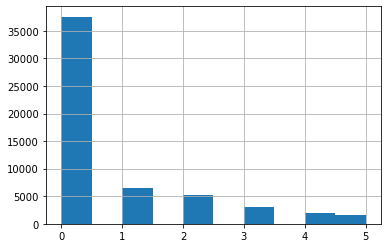

In [281]:
sf.activity.hist()

In [282]:
path = r'D:\niimpy\niimpy\sampledata\sl_activity.csv'
sf.to_csv(path)

In [284]:
sf

user  activity group
timestamp                                     
2013-03-27 06:00:00-05:00  u00         2  none
2013-03-27 07:00:00-05:00  u00         1  none
2013-03-27 08:00:00-05:00  u00         2  none
2013-03-27 09:00:00-05:00  u00         3  none
2013-03-27 10:00:00-05:00  u00         4  none
...                        ...       ...   ...
2013-05-31 18:00:00-05:00  u59         5  mild
2013-05-31 19:00:00-05:00  u59         5  mild
2013-05-31 20:00:00-05:00  u59         4  mild
2013-05-31 21:00:00-05:00  u59         5  mild
2013-05-31 22:00:00-05:00  u59         1  mild

[55907 rows x 3 columns]

## 1) one time series

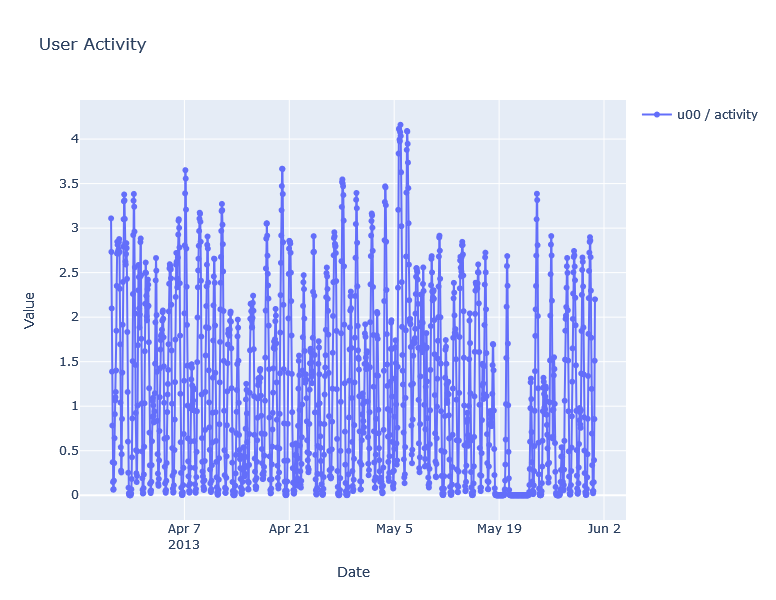

In [283]:
columns = ['activity']
title = 'User Activity'
xlabel = 'Date'
ylabel = 'Value'
users = ['u00']
resample = False
interpolate = False
window_len = 24
resample = 'H'

fig = EDA_lineplot.timeplot(sf,
                            users,
                            columns,
                            title ,
                            xlabel,
                            ylabel,
                            resample,
                            interpolate,
                            window_len,
                            )

fig.show()

## 1 b) Reset index

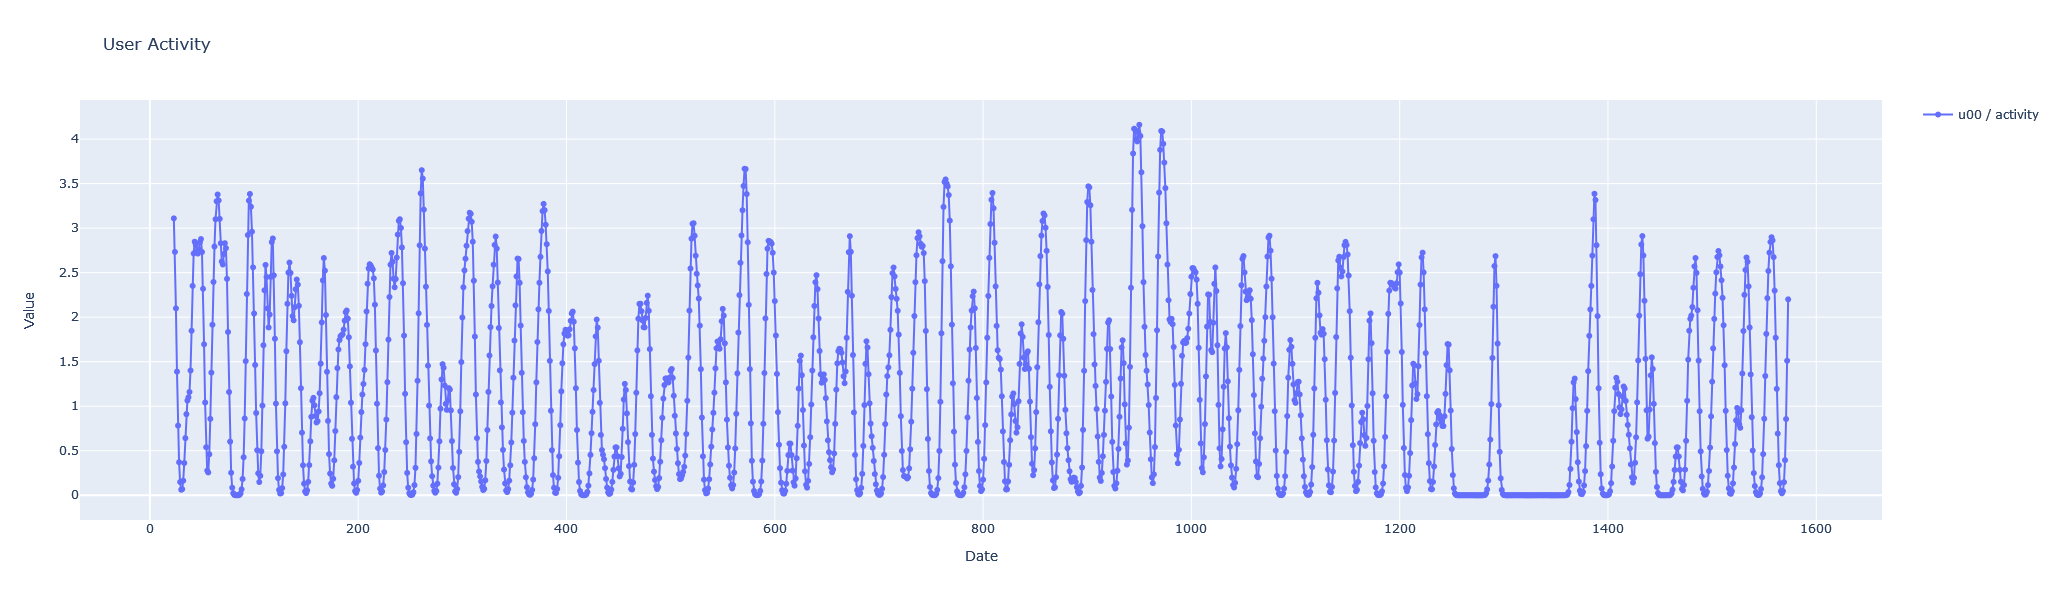

In [286]:
columns = ['activity']
title = 'User Activity'
xlabel = 'Date'
ylabel = 'Value'
users = ['u00']
resample = True
interpolate = True
window_len = 24
resample = 'H'
reset_index = True

fig = EDA_lineplot.timeplot(sf,
         users,
         columns,
         title ,
         xlabel,
         ylabel,
         resample,
         interpolate,
         window_len,
         reset_index
        )

fig.show()

## 1 c) Sampled by day

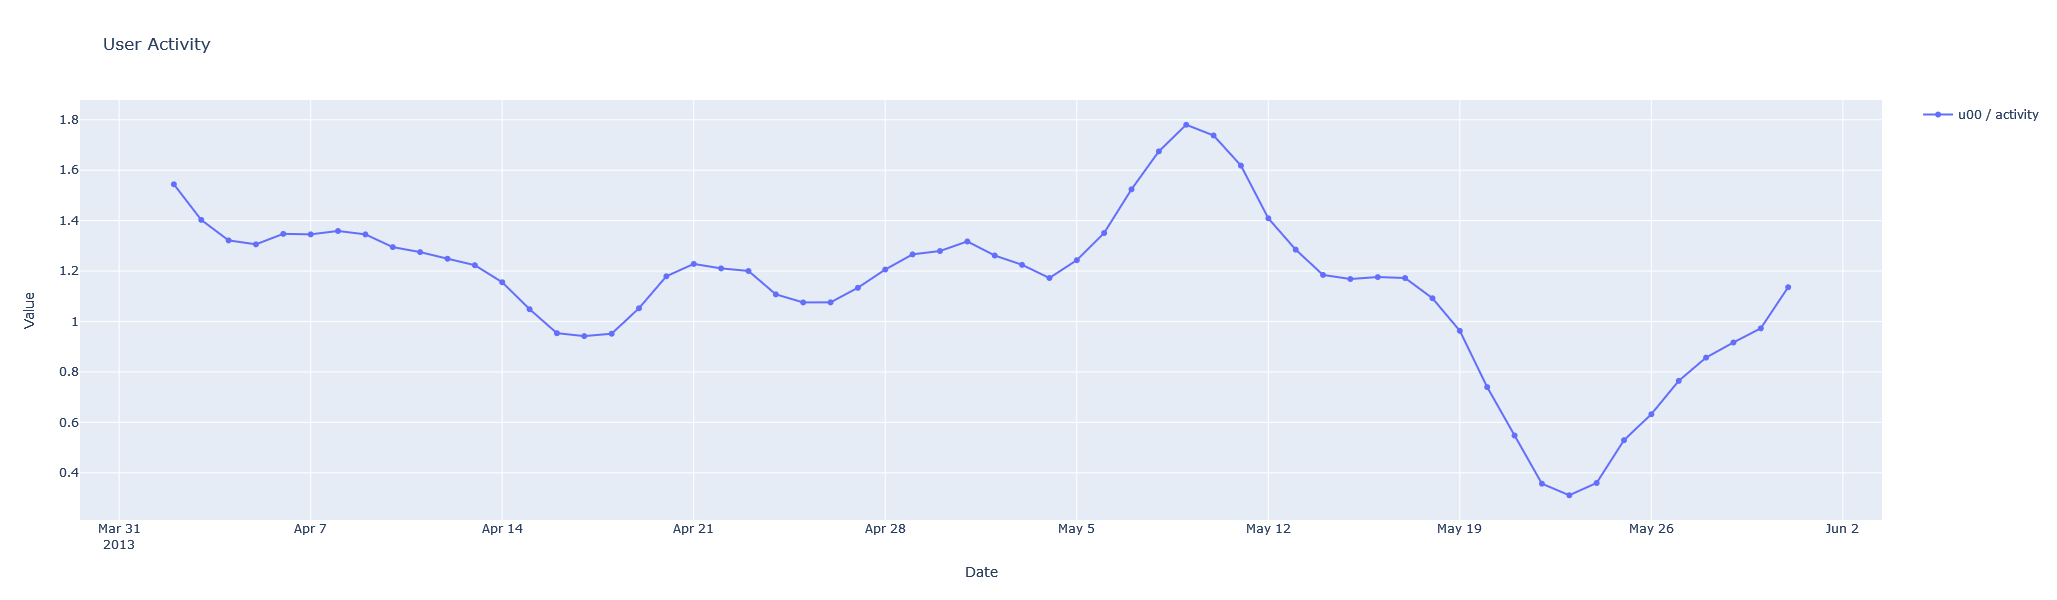

In [287]:
columns = ['activity']
title = 'User Activity'
xlabel = 'Date'
ylabel = 'Value'
users = ['u00']
resample = True
interpolate = True
window_len = 7
resample = 'D'

fig = EDA_lineplot.timeplot(sf,
         users,
         columns,
         title ,
         xlabel,
         ylabel,
         resample,
         interpolate,
         window_len,
        )

fig.show()

## 2) two users

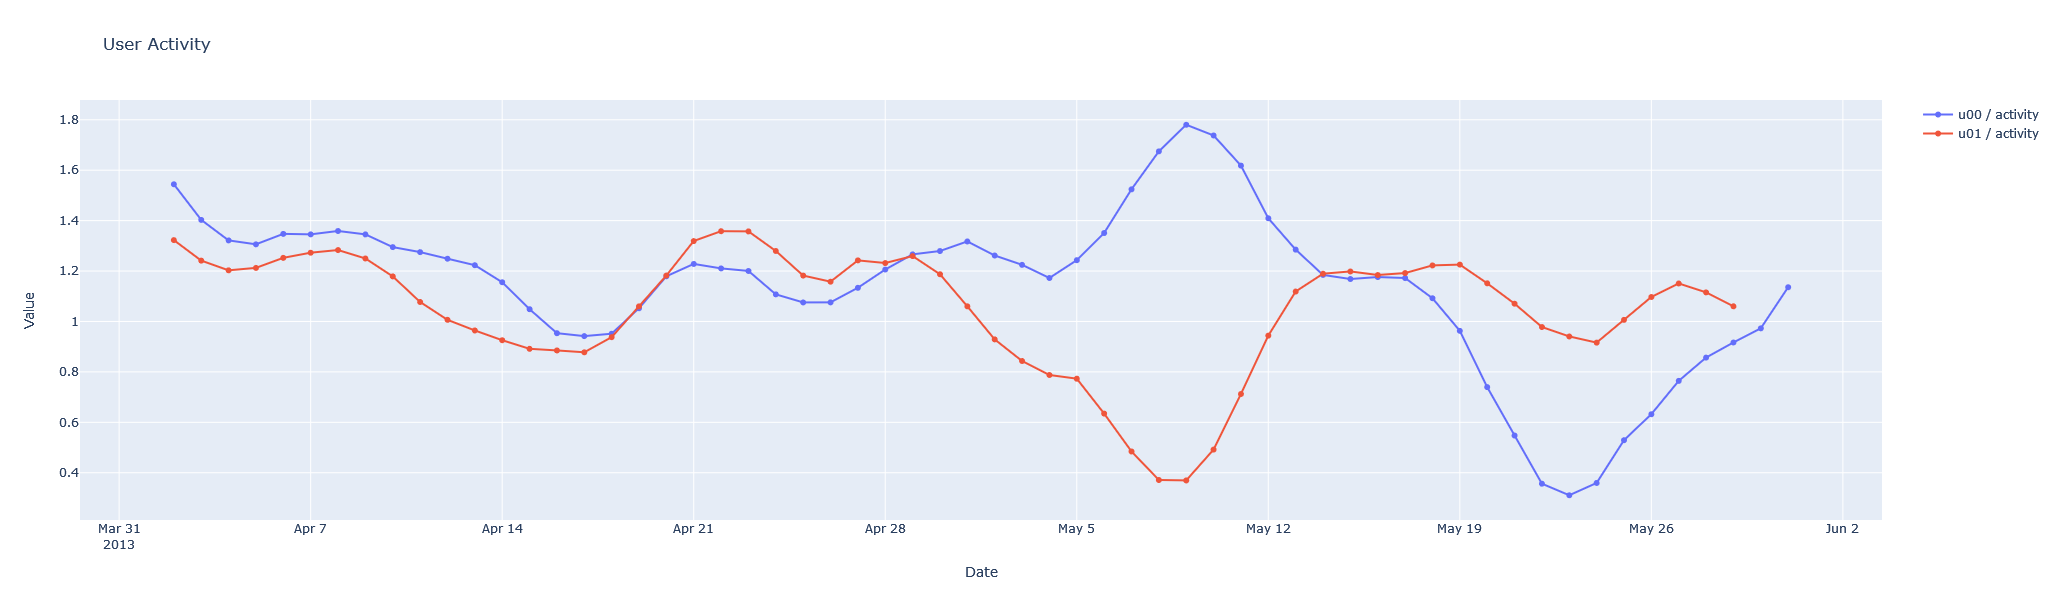

In [288]:
columns = ['activity']
title = 'User Activity'
xlabel = 'Date'
ylabel = 'Value'
users = ['u00','u01']
resample = True
interpolate = True
window_len = 7
resample = 'D'

fig = EDA_lineplot.timeplot(sf,
         users,
         columns,
         title ,
         xlabel,
         ylabel,
         resample,
         interpolate,
         window_len,
        )

fig.show()

## 3) group level hourly averages

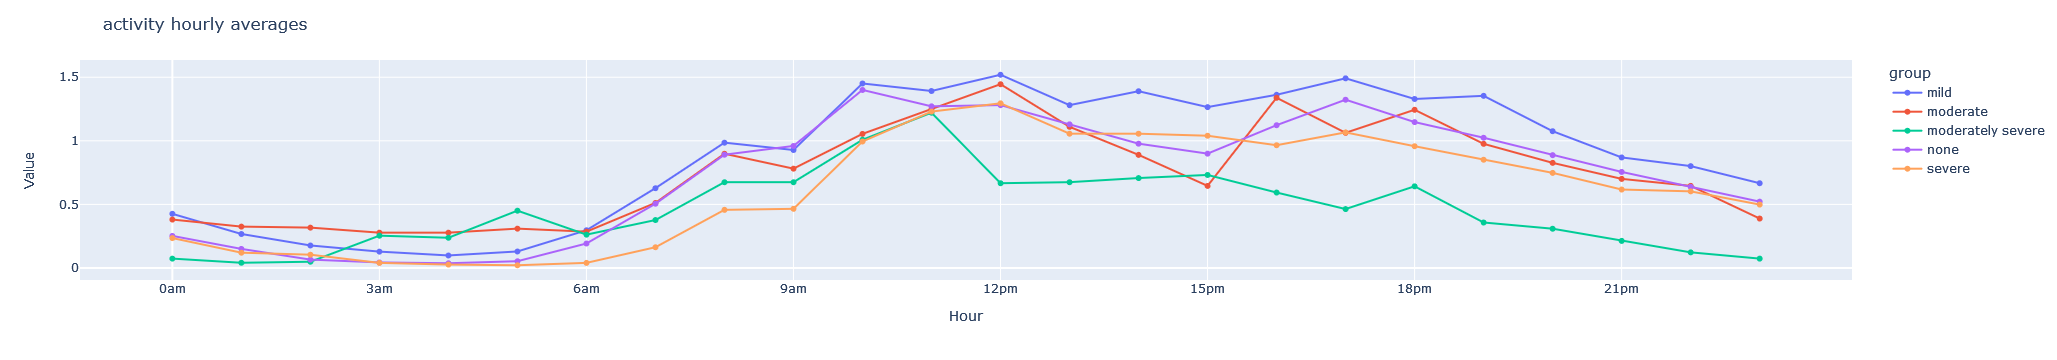

In [289]:
users = 'Group'
columns = ['activity']
title = 'User Activity'
xlabel = 'Date'
ylabel = 'Value'
smooth = True
resample = True
window_len = 7
interpolate = True
resample = 'D'
reset_index = False
by = 'hour'

fig = EDA_lineplot.timeplot(sf,
                            users,
                            columns,
                            title ,
                            xlabel,
                            ylabel,
                            resample,
                            interpolate,
                            window_len,
                            reset_index,
                            by
                            )

fig.show()

In [ ]:
column = 'activity'
by = 'hour'
averages = EDA_lineplot.calculate_averages_(dick_frame,column, by)

In [ ]:
averages

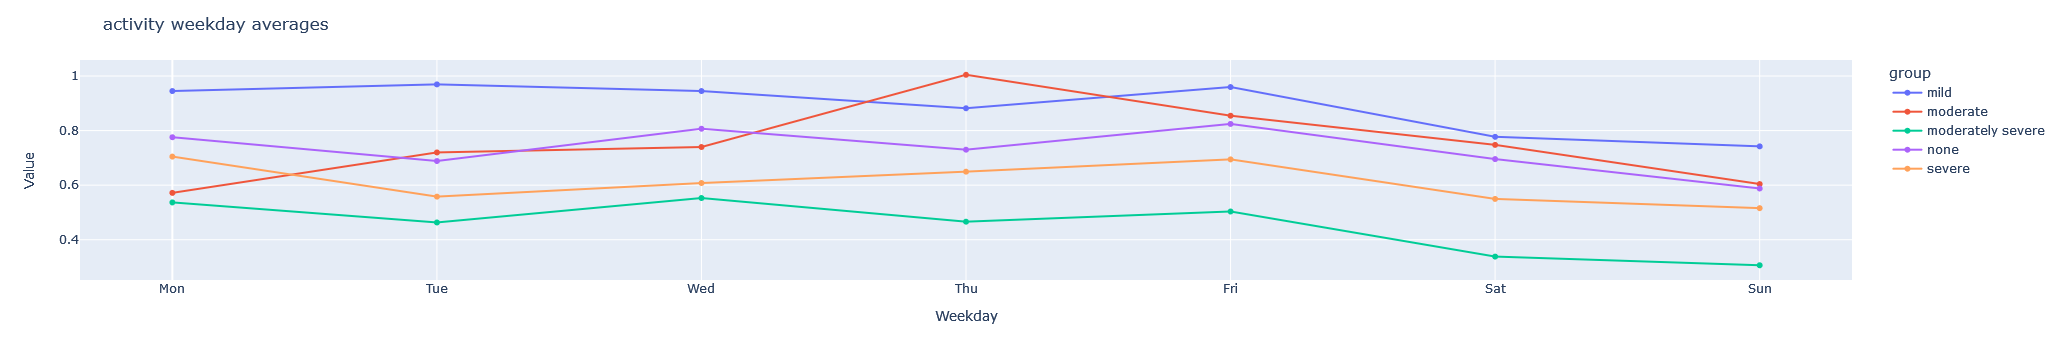

In [290]:
users = 'Group'
columns = ['activity']
title = 'User Activity'
xlabel = 'Date'
ylabel = 'Value'
smooth = True
resample = True
window_len = 7
interpolate = True
resample = 'D'
reset_index = False
by = 'weekday'

fig = EDA_lineplot.timeplot(sf,
                            users,
                            columns,
                            title ,
                            xlabel,
                            ylabel,
                            resample,
                            interpolate,
                            window_len,
                            reset_index,
                            by
                            )

fig.show()

## 4) countplot with sl data


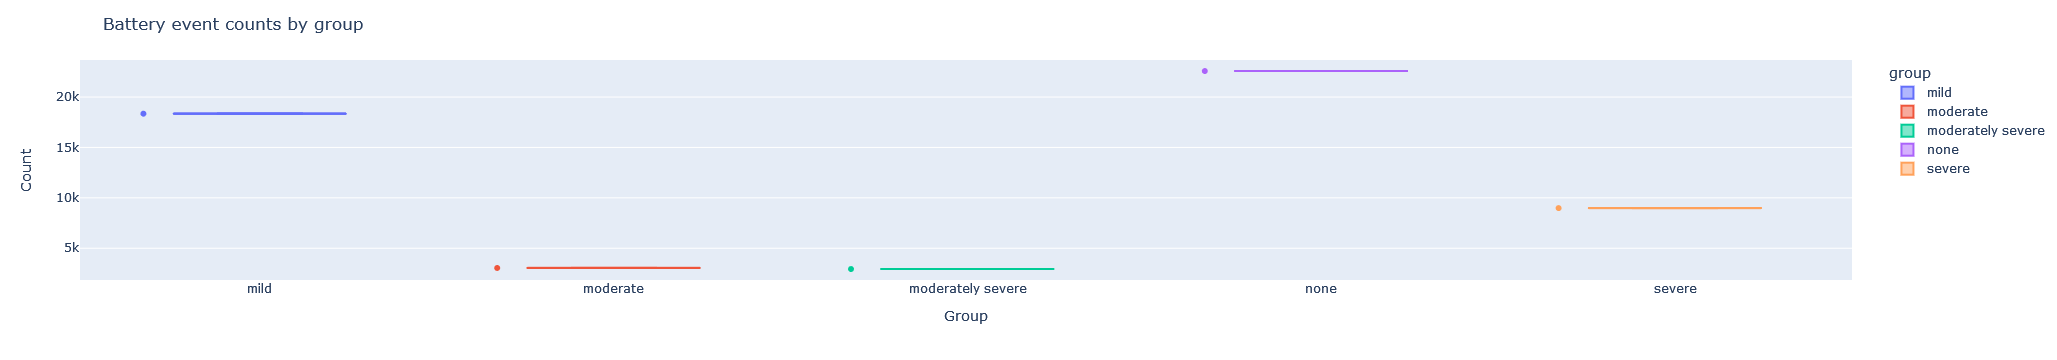

In [291]:
EDA_countplot.EDA_countplot(sf, 
                            fig_title = 'Battery event counts by group', 
                            plot_type = 'count', 
                            points = 'all',
                            aggregation = 'group', 
                            user = None, 
                            column=None,
                            binning=False)

In [292]:
bins = sf.index.to_period('D')
bins = bins.to_series().astype(str)
sf['bins'] = bins.values

C:\Users\arsii\anaconda3\envs\CS\lib\site-packages\pandas\core\arrays\datetimes.py:1143: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



In [293]:
import sys
sys.path.append('/scratch/cs/networks-nima-mmm2018/Arsi/niimpy_fork/niimpy')
import numpy as np
import pandas as pd
import niimpy
import plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.templates.default = "seaborn"
px.defaults.template = "ggplot2"
px.defaults.color_continuous_scale = px.colors.sequential.RdBu
px.defaults.width = 1200
px.defaults.height = 482

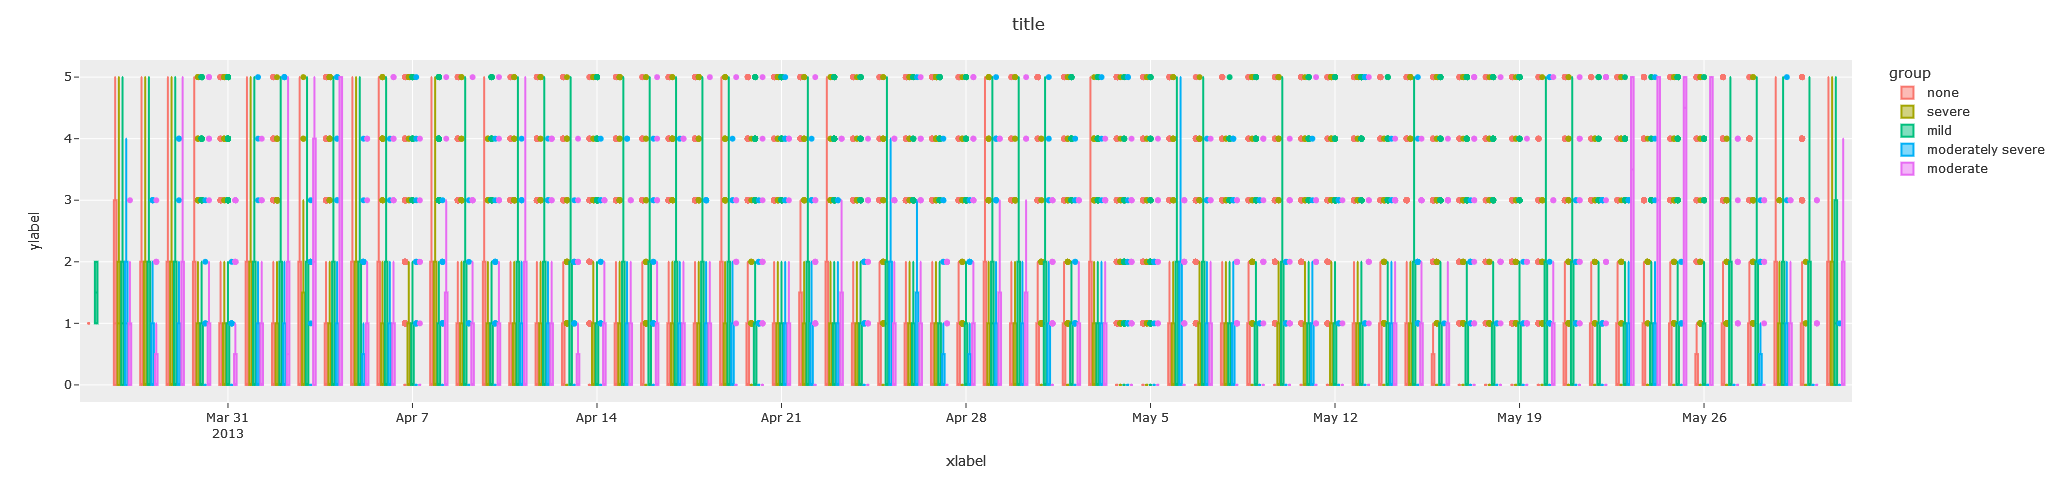

In [294]:
fig = px.box(sf,
                     x = "bins", 
                     y = 'activity',
                     color = "group",
                     )

fig.update_traces(quartilemethod='inclusive') # or "inclusive", or "linear" by default
fig.update_layout(title = 'title',
                    xaxis_title = 'xlabel',
                      yaxis_title ='ylabel',
                      autotypenumbers='convert types') 
    
fig.show()

In [296]:
sf

user  activity group        bins
timestamp                                                 
2013-03-27 06:00:00-05:00  u00         2  none  2013-03-27
2013-03-27 07:00:00-05:00  u00         1  none  2013-03-27
2013-03-27 08:00:00-05:00  u00         2  none  2013-03-27
2013-03-27 09:00:00-05:00  u00         3  none  2013-03-27
2013-03-27 10:00:00-05:00  u00         4  none  2013-03-27
...                        ...       ...   ...         ...
2013-05-31 18:00:00-05:00  u59         5  mild  2013-05-31
2013-05-31 19:00:00-05:00  u59         5  mild  2013-05-31
2013-05-31 20:00:00-05:00  u59         4  mild  2013-05-31
2013-05-31 21:00:00-05:00  u59         5  mild  2013-05-31
2013-05-31 22:00:00-05:00  u59         1  mild  2013-05-31

[55907 rows x 4 columns]

In [295]:
EDA_countplot.EDA_countplot(sf, 
                            fig_title = 'Activity boxplots by day', 
                            plot_type = 'value', 
                            points = 'all',
                            aggregation = 'group', 
                            user = None, 
                            column='activity',
                            binning='D')

ValueError: cannot reindex from a duplicate axis